# **Travel Insurance Claim Prediction**

## A. Business Understanding

### Context
Travel insurance is a product typically purchased by customers prior to a trip to cover potential risks like cancellations, medical emergencies, or other incidents that may arise during travel. Unlike other types of insurance, travel insurance is usually a one-time purchase and does not require ongoing monthly payments. This creates a unique challenge for the insurance company, as the financial impact of claims can be significant, and the company has limited opportunities to recover costs through future payments. A company engaged in travel insurance wants to predict which policyholders will submit an insurance claim for travel coverage. Policyholder data includes information such as destination, travel insurance products, and historical data regarding claims. The ability to predict claim submissions can help the company better manage risk, allocate resources efficiently, and improve overall profitability.

Target:

0 : No claim submitted

1 : Claim submitted

### Problem Statement
The primary problem faced by the travel insurance company is accurately predicting which customers are likely to file claims. Misclassifying customers can lead to either increased operational costs (in the case of false positives) or substantial financial losses (in the case of false negatives). The company needs a robust model to minimize incorrect predictions, as both false positives and false negatives can have serious financial consequences.

### Goals
The company seeks to predict the likelihood of a customer filing a claim after purchasing a travel insurance policy. This would help them allocate resources efficiently, adjust premiums based on risk factors, and develop strategies to reduce claim submissions.

Additionally, the company wants to understand what factors drive customers to submit claims, allowing them to refine their offerings and provide better customer service while managing risk.

### Analytic Approach:
We will analyze the data to identify patterns that distinguish customers who submit claims from those who do not. Then, we will build a classification model to predict the likelihood of a policyholder submitting a claim, allowing the company to focus on high-risk customers for better risk management.

### Metric Evaluation:

We will focus on the following errors:

* Type 1 Error (False Positive):

    Predicting a customer will submit a claim when they will not.
    - Consequence: Losing profit, since the customer won't buy the one-time purchase insurance.

* Type 2 Error (False Negative):

    Predicting a customer will not submit a claim when they will.
    - Consequence: Unprepared for claim submissions, leading to financial strain.

The main metric for evaluation will be F1-Score as it balances both precision and recall, ensuring that the model minimizes both false positives and false negatives while capturing true risks efficiently.


## B. Data Understanding

The dataset contains information about policyholders from a third-party travel insurance service company based in Singapore. 
Online Access: https://www.kaggle.com/datasets/mhdzahier/travel-insurance.

Here's Dataset's attribute informaton:

| Attribute               | Data Type         | Description                                           |
|-------------------------|-------------------|-------------------------------------------------------|
| Agency                  | Text              | The agency offering the insurance policy              |
| Agency Type             | Text              | Type of agency (e.g., Airlines, Travel Agency)        |
| Distribution Channel    | Text              | The method used for distributing the policy (Online)  |
| Product Name            | Text              | The name of the insurance product                     |
| Gender                  | Text              | Gender of the customer (M = Male, F = Female)         |
| Duration                | Integer           | Duration of the policy in days                        |
| Destination             | Text              | The destination where the policyholder is traveling   |
| Net Sales               | Float             | Total sales amount for the policy                     |
| Commision (in value)    | Float             | The commission earned for the policy sale             |
| Age                     | Integer           | Age of the policyholder                               |
| Claim                   | Text              | Whether a claim was made (Yes/No)                     |


In [2]:
# Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics
from scipy.stats import shapiro, spearmanr, probplot, randint, uniform

# Data Imputation
from sklearn.impute import KNNImputer

# Encoding and Preprocessing
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                   RobustScaler, MinMaxScaler, PolynomialFeatures, 
                                   FunctionTransformer, PowerTransformer, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from imblearn.pipeline import Pipeline, make_pipeline


# Sampling Methods
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek

# Model Algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Evaluation and Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectPercentile, RFE

# Deployment
import pickle

In [3]:
df_raw = pd.read_csv('data_travel_insurance.csv')
df_raw.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


### 1. Data Size and Column Information

In [4]:
df_raw.shape

(44328, 11)

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [6]:
df_raw.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Gender', 'Duration', 'Destination', 'Net Sales',
       'Commision (in value)', 'Age', 'Claim'],
      dtype='object')

> Insight:
* The dataset includes both categorical and numerical features. Categorical features include Agency, Product Name, Distribution Channel, and others, while numerical features are Net Sales, Commission (in value), and Duration.
* The Product Name and Agency columns may have high cardinality, representing a variety of different products and agencies.
* There are some missing values in the Gender column.
* Each row in the dataset represents an individual travel insurance policy and its associated details, such as the agency offering the policy, the type of product, the customer’s details, and the sales and claim information.

In [7]:
# Adjusting colomns name for easier data access
df_raw = df_raw.rename(columns={'Agency Type':'Agency_Type', 'Distribution Channel':'Distribution_Channel', 'Product Name':'Product_Name',
        'Net Sales':'Net_Sales','Commision (in value)':'Commision_in_value'})
df_raw['Claim'] = np.where(df_raw['Claim']=='Yes',1,0)

In [8]:
df = df_raw.copy()
df.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,0


### 2. Checking Unique Values

In [9]:
# Checking each column unique value
listItem = []
for i in df.columns:
    count_unique = df[i].nunique()
    unique_value = df[i].unique()
    listItem.append([i, count_unique, unique_value])

unique_table = pd.DataFrame(data=listItem, columns=['Column Name', 'Count of Unique Value', 'Unique Values'])
unique_table

,Column Name,Count of Unique Value,Unique Values
0,Agency,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, ..."
1,Agency_Type,2,"[Airlines, Travel Agency]"
2,Distribution_Channel,2,"[Online, Offline]"
3,Product_Name,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Gender,2,"[F, nan, M]"
5,Duration,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 37..."
6,Destination,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
7,Net_Sales,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 8..."
8,Commision_in_value,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88,..."
9,Age,89,"[57, 33, 26, 59, 28, 36, 22, 39, 27, 48, 43, 5..."


> Insight:
* All the data values ​​in each column have been consistent, meaning there are no redundant terms for one value

## C. Data Cleaning

### 1. Handle Missing Values

In [10]:
# Check missing values in all columns
print("Missing values in each column:")
print(df.isnull().sum())
print("\n")

Missing values in each column:
Agency                      0
Agency_Type                 0
Distribution_Channel        0
Product_Name                0
Gender                  31647
Duration                    0
Destination                 0
Net_Sales                   0
Commision_in_value          0
Age                         0
Claim                       0
dtype: int64




In [11]:
# Count Proportion Missing Value
counts = df['Gender'].value_counts(dropna=False)
total = counts.sum()
proportions = counts / total * 100
for value, proportion in proportions.items():
    if pd.isna(value):  # Handle missing values
        print(f"Total missing values in Gender column = {proportion:.2f}%")
    else:
        print(f"{value} = {proportion:.2f}%")

Total missing values in Gender column = 71.39%
M = 14.67%
F = 13.93%


In [12]:
# Drop column and check wether there's any missing values
df = df.drop(['Gender'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency_Type           44328 non-null  object 
 2   Distribution_Channel  44328 non-null  object 
 3   Product_Name          44328 non-null  object 
 4   Duration              44328 non-null  int64  
 5   Destination           44328 non-null  object 
 6   Net_Sales             44328 non-null  float64
 7   Commision_in_value    44328 non-null  float64
 8   Age                   44328 non-null  int64  
 9   Claim                 44328 non-null  int32  
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 3.2+ MB


> Insight: 
* The Gender column in the dataset had 71.39% missing values, which is significantly high. Due to the large proportion of missing data, it was not practical to use an imputer to fill the missing values. Therefore, the Gender column was dropped from the dataset to maintain data integrity and to avoid introducing bias or inaccuracies with imputation methods.

### 2. Handling Outlier

In [13]:
df.columns

Index(['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name',
       'Duration', 'Destination', 'Net_Sales', 'Commision_in_value', 'Age',
       'Claim'],
      dtype='object')

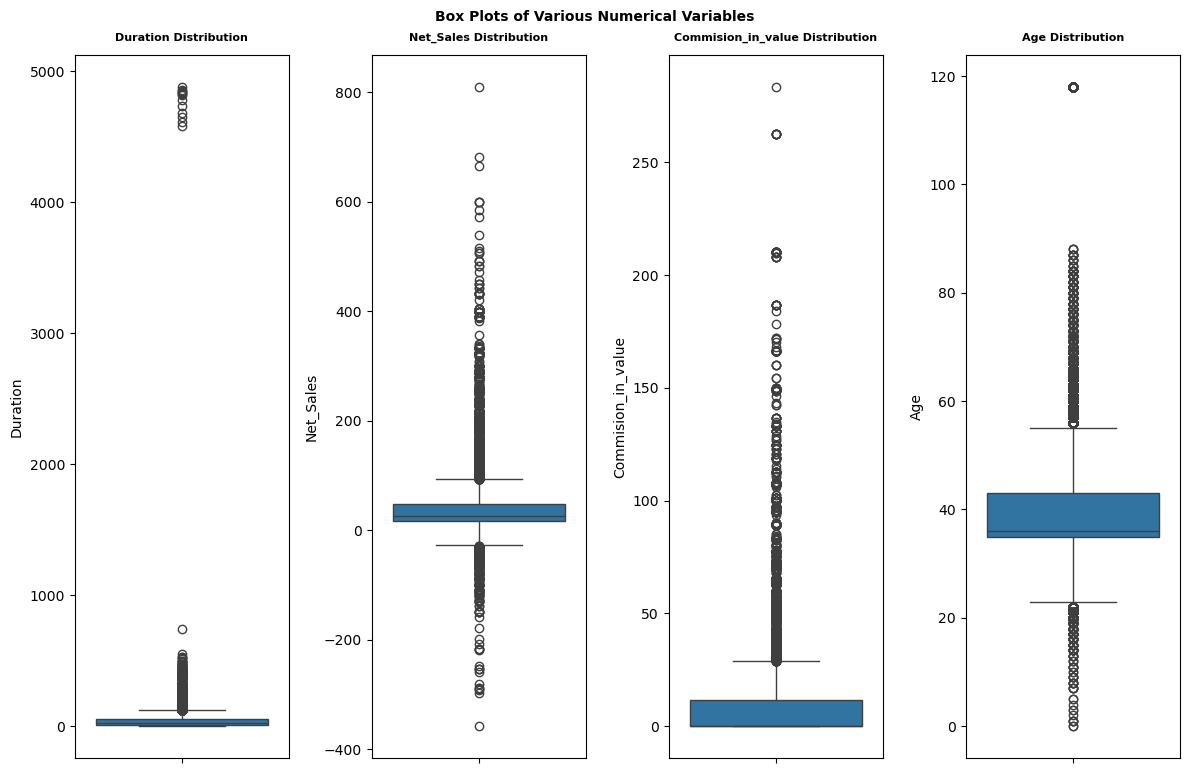

In [14]:
col = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 8))
axes = axes.flatten()

# Perbaikan dengan mengelola enumerate dengan benar
for i, c in enumerate(col):
    sns.boxplot(data=df, y=c, ax=axes[i])  # Gunakan c untuk setiap kolom
    axes[i].set_title(f'{c} Distribution', pad=10, fontweight='bold', fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(c)

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.suptitle('Box Plots of Various Numerical Variables', fontsize=10, fontweight='bold')
plt.show()


In [15]:
df.describe()

,Duration,Net_Sales,Commision_in_value,Age,Claim
count,44328.000000,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600,0.015273
std,109.153961,48.661970,19.625637,13.954926,0.122636
min,-1.000000,-357.500000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,26.500000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,11.550000,43.000000,0.000000
max,4881.000000,810.000000,283.500000,118.000000,1.000000


In [16]:
df = df[df['Duration']>=0]
df = df[(df['Net_Sales']>=0) & (df["Net_Sales"]>df["Commision_in_value"])]
df = df[(df['Age']>=0) & (df['Age']<100)]

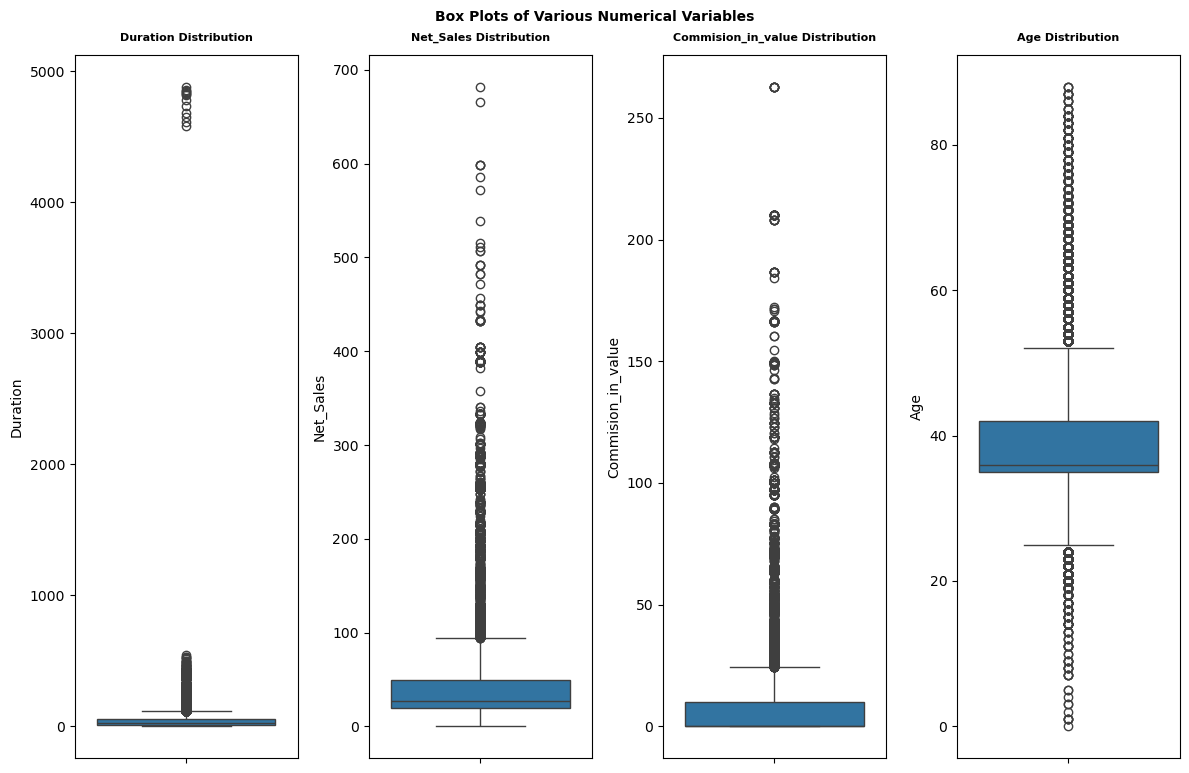

In [17]:
col = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 8))
axes = axes.flatten()

# Perbaikan dengan mengelola enumerate dengan benar
for i, c in enumerate(col):
    sns.boxplot(data=df, y=c, ax=axes[i])  # Gunakan c untuk setiap kolom
    axes[i].set_title(f'{c} Distribution', pad=10, fontweight='bold', fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(c)

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.suptitle('Box Plots of Various Numerical Variables', fontsize=10, fontweight='bold')
plt.show()

> Insight:
* Negative values in the Duration column have been removed since time cannot be negative.
* Negative values and Values fewer than Commision in the Net_Sales column have been eliminated, as sales prices should not logically fall below zero and commision.
* The Age column has been limited to a range of 0 to 100 to exclude unrealistic or erroneous data entries.

### 3. Checking Duplicate Data

In [18]:
# Find whether data is duplicate
print(f"Sum of duplicates rows in this dataset: {df.duplicated().sum()}")

Sum of duplicates rows in this dataset: 4705


In [19]:
# Handling duplicate rows
df.drop_duplicates(inplace=True)
if df.duplicated().sum() > 0:
    print(f"Sum of duplicates rows in this dataset: {df.duplicated().sum()}")
else:
    print("There's no more duplicate rows")

There's no more duplicate rows


> Insight:
The dataset had 4705 duplicate rows, which were removed to prevent issues model bias, overfitting, and inaccurate predictions that leading to incorrect predictions and reducing the model's performance.

## D. Exploratory Data Analysis

In [20]:
df_cleaned = df.copy()

### 1. Statistik Deskriptif

In [21]:
print('Descriptive Statistics for numeric columns:')
display(df_cleaned.select_dtypes(include = 'number').describe())
print('Descriptive Statistics for categoric columns:')
display(df_cleaned.select_dtypes(exclude = 'number').describe())

Descriptive Statistics for numeric columns:


,Duration,Net_Sales,Commision_in_value,Age,Claim
count,37195.000000,37195.000000,37195.000000,37195.000000,37195.000000
mean,52.111709,44.730364,9.732106,39.001828,0.017906
std,115.369460,48.336184,19.904107,10.455636,0.132610
min,0.000000,0.130000,0.000000,0.000000,0.000000
25%,11.000000,20.000000,0.000000,35.000000,0.000000
50%,25.000000,29.700000,0.000000,36.000000,0.000000
75%,56.000000,52.000000,10.500000,44.000000,0.000000
max,4881.000000,682.000000,262.760000,88.000000,1.000000


Descriptive Statistics for categoric columns:


,Agency,Agency_Type,Distribution_Channel,Product_Name,Destination
count,37195,37195,37195,37195,37195
unique,15,2,2,25,134
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,20486,26570,36556,10751,7904


### 2. Distribution Data

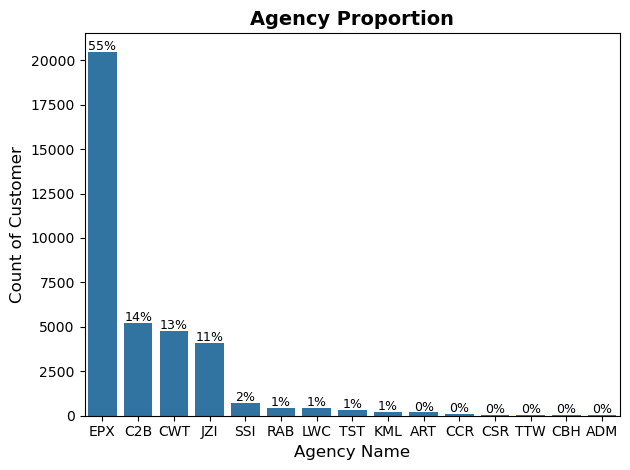

In [22]:
total = len(df_cleaned)
ax = sns.countplot(data=df_cleaned, x='Agency', order=df_cleaned['Agency'].value_counts().index)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.0f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()+300),  
                ha = 'center', va = 'center', fontsize=9, color='black')

plt.title('Agency Proportion', fontsize=14, weight='bold')
plt.xlabel('Agency Name', fontsize=12)
plt.ylabel('Count of Customer', fontsize=12)
plt.tight_layout()
plt.show()

> Insight: 
* The majority of customers are enrolled with the EPX, C2B, CWT, and JZI travel agencies. Specifically:
  - 71% of the total customer data comes from Travel Agencies, while 29% comes from Airlines. This indicates that most customers prefer using travel agency services rather than dealing directly with airlines.

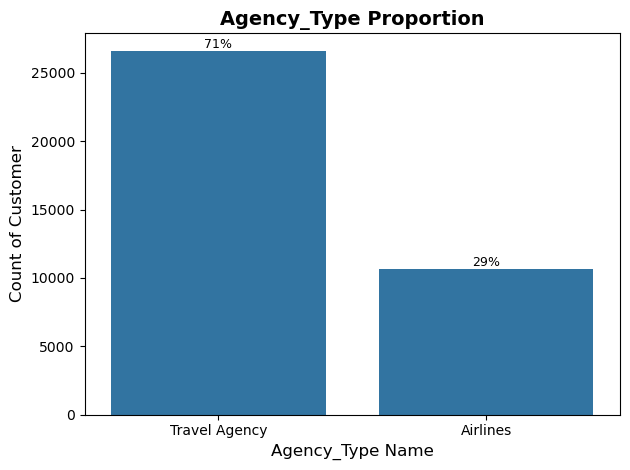

In [23]:
total = len(df_cleaned)
ax = sns.countplot(data=df_cleaned, x='Agency_Type', order=df_cleaned['Agency_Type'].value_counts().index)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.0f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()+500),  
                ha = 'center', va = 'center', fontsize=9, color='black')

plt.title('Agency_Type Proportion', fontsize=14, weight='bold')
plt.xlabel('Agency_Type Name', fontsize=12)
plt.ylabel('Count of Customer', fontsize=12)
plt.tight_layout()
plt.show()

> Insight: 
* 71% of the total customer data comes from **Travel Agency**, while 29% comes from **Airlines**. This shows that the majority of customers prefer using travel agency services rather than dealing directly with airlines.

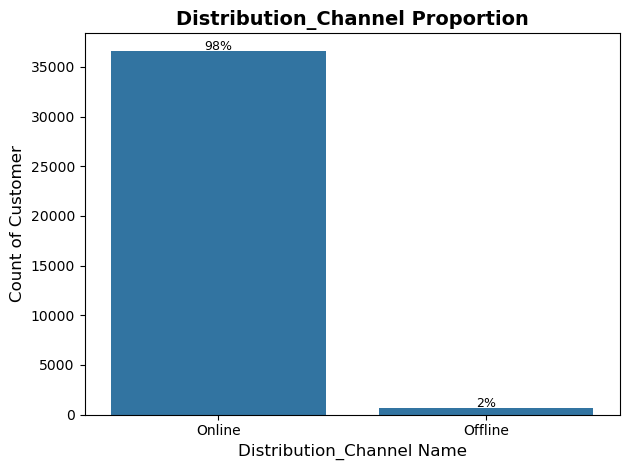

In [24]:
total = len(df_cleaned)
ax = sns.countplot(data=df_cleaned, x='Distribution_Channel', order=df_cleaned['Distribution_Channel'].value_counts().index)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.0f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()+500),  
                ha = 'center', va = 'center', fontsize=9, color='black')

plt.title('Distribution_Channel Proportion', fontsize=14, weight='bold')
plt.xlabel('Distribution_Channel Name', fontsize=12)
plt.ylabel('Count of Customer', fontsize=12)
plt.tight_layout()
plt.show()

> Insight: 
* 98% of the total customer data comes from online channels, while only 2% comes from offline channels. This indicates that the vast majority of customers prefer using online platforms for their transactions.

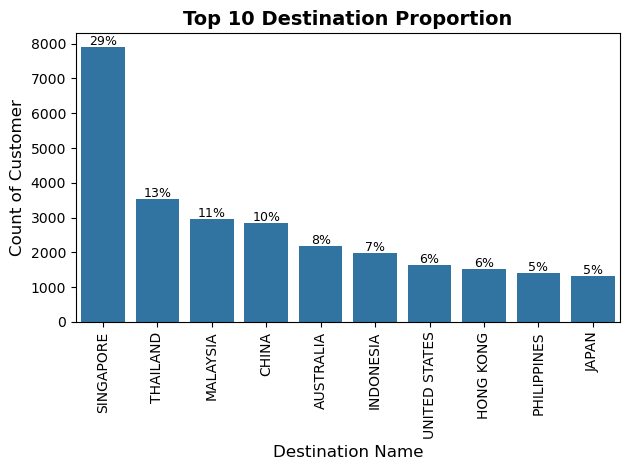

In [25]:
# Mengambil 10 destinasi terbesar berdasarkan count
top_10_destinations = df_cleaned['Destination'].value_counts().nlargest(10).index

ax = sns.countplot(data=df_cleaned[df_cleaned['Destination'].isin(top_10_destinations)], 
                   x='Destination', order=top_10_destinations)

total = len(df_cleaned[df_cleaned['Destination'].isin(top_10_destinations)])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.0f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()+ 150),  
                ha='center', va='center', fontsize=9, color='black')

plt.title('Top 10 Destination Proportion', fontsize=14, weight='bold')
plt.xlabel('Destination Name', fontsize=12)
plt.ylabel('Count of Customer', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


> Insight:
  
* Favorite Destination: Singapore

Singapore is the most popular destination, with 29% of customers choosing it. This indicates that the country is the top choice for customers or users in this dataset.
As the most popular destination, Singapore likely has a special appeal, either for business, tourism, or easier accessibility compared to other destinations.

* Uneven Distribution:

After Singapore, there is a significant drop in the number of customers. Thailand comes in second with 13%, followed by Malaysia with 11%.
The drop from the first destination (Singapore) to the second (Thailand) is quite sharp, which may indicate that Singapore has a much stronger attraction than the other destinations.

In [26]:
df_cleaned.columns

Index(['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name',
       'Duration', 'Destination', 'Net_Sales', 'Commision_in_value', 'Age',
       'Claim'],
      dtype='object')

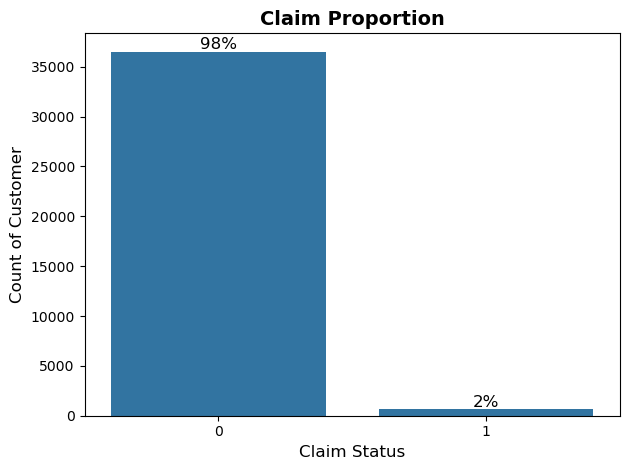

In [27]:
total = len(df_cleaned)
ax = sns.countplot(data=df_cleaned, x='Claim', order=df_cleaned['Claim'].value_counts().index)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.0f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()+700),  
                ha = 'center', va = 'center', fontsize=12, color='black')

plt.title('Claim Proportion', fontsize=14, weight='bold')
plt.xlabel('Claim Status', fontsize=12)
plt.ylabel('Count of Customer', fontsize=12)
plt.tight_layout()
plt.show()


In [28]:
df_cleaned['Claim'].value_counts()

Claim
0    36529
1      666
Name: count, dtype: int64

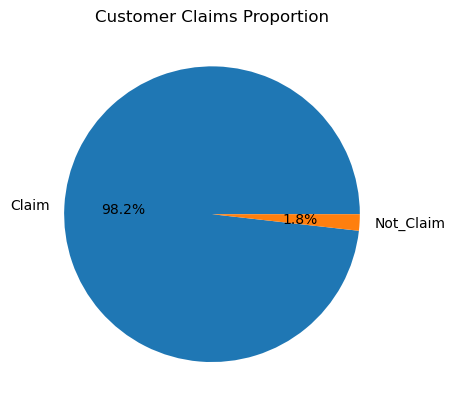

In [29]:
train_agg=df_cleaned['Claim'].value_counts(normalize=1).reset_index()
train_agg['percentage']=100*train_agg['proportion']
train_agg


plt.pie(data=train_agg,x='percentage',labels=['Claim','Not_Claim'], autopct='%1.1f%%'
       ,textprops=dict())
plt.title('Customer Claims Proportion')
plt.show()

> Insight: There are more customers who don't claim their insurance than those who do. This indicates that this is a highly imbalanced data set that will need to be balanced later to ensure that it does not adversely impact the performance of the machine learning algorithm.

### 3. Bivariate Analysis

In [30]:
train_label = df_cleaned.select_dtypes(include='number')
train_label

,Duration,Net_Sales,Commision_in_value,Age,Claim
0,365,216.0,54.00,57,0
1,4,10.0,0.00,33,0
2,19,22.0,7.70,26,0
3,20,112.0,0.00,59,0
4,8,16.0,4.00,28,0
...,...,...,...,...,...
44322,6,40.0,0.00,36,0
44323,14,30.0,0.00,36,1
44324,17,79.2,47.52,47,0
44325,64,30.0,10.50,50,0


#### 1. Numeric Column

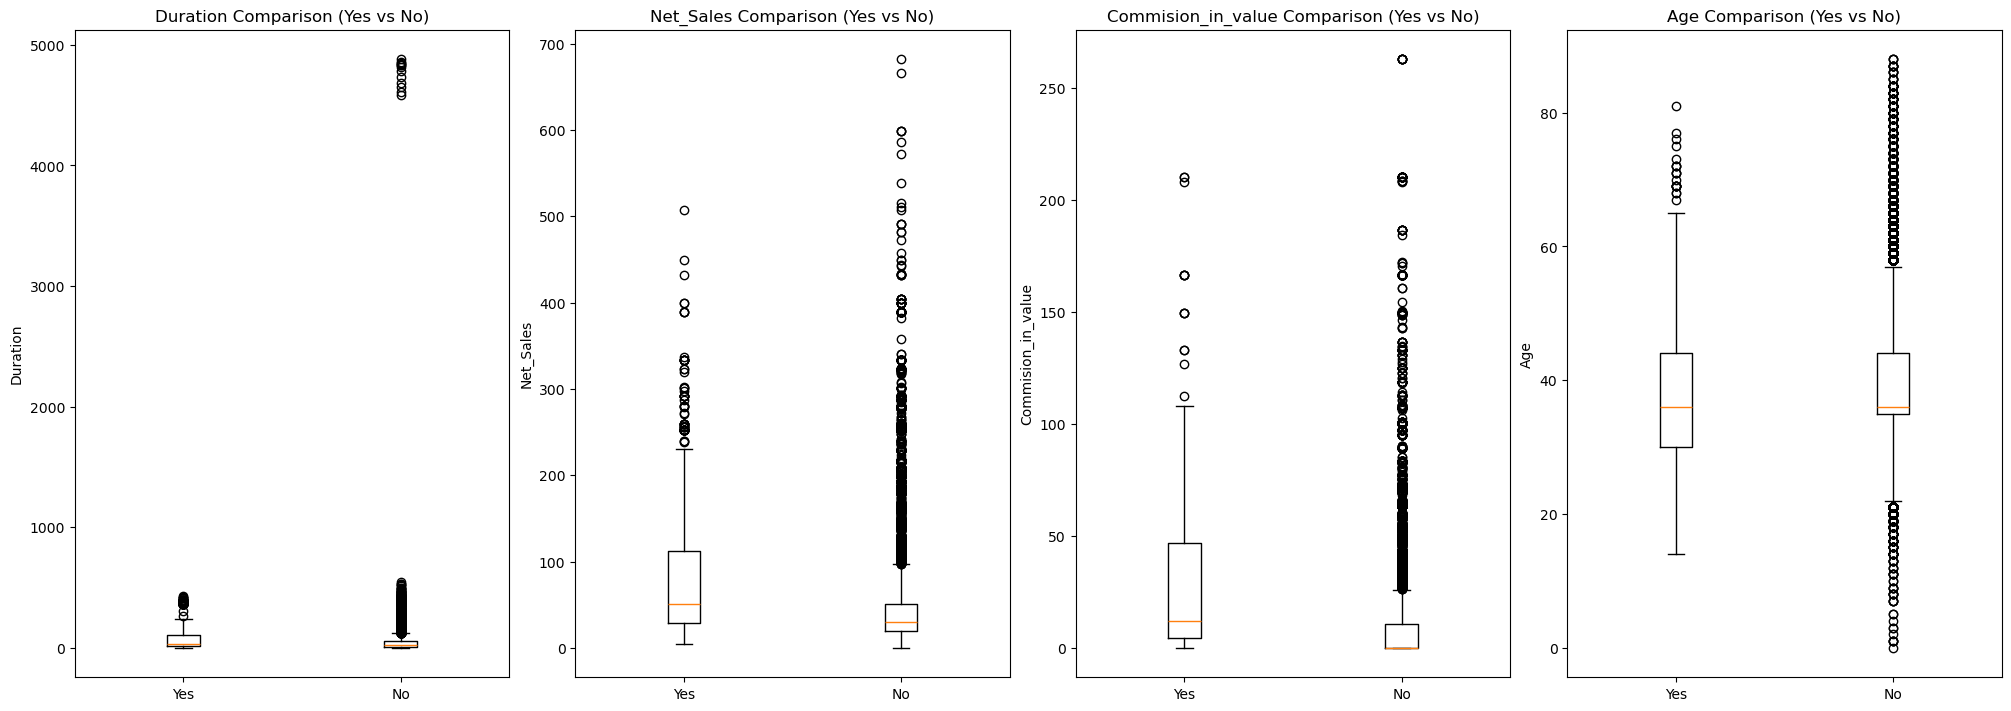

In [31]:
claim_yes = train_label[train_label['Claim'] == 1]
claim_no = train_label[train_label['Claim'] == 0]

num_cols = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']

fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 7), constrained_layout=True)

for ax, col in zip(axes, num_cols):
    ax.boxplot([claim_yes[col], claim_no[col]])
    ax.set_xticklabels(['Yes', 'No'])
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison (Yes vs No)')

plt.show()


> Insight:
The comparison between Yes and No categories across four variables:

**Duration Comparison (Yes vs No):**
* The duration for both Yes and No categories is relatively low, but there are more outliers (extreme values) in the No category compared to Yes.
* Both categories show a small range of values overall, but the outliers in the No category suggest that some transactions have significantly longer durations.

**Net Sales Comparison (Yes vs No):**

* The median Net Sales for the Yes category is higher than that for the No category.
* Most Net Sales for the No category fall in the lower range, while there are several high outliers in both categories, particularly in the Yes category.
* This indicates that transactions in the Yes category tend to generate higher net sales compared to those in the No category.

**Commission_in_value Comparison (Yes vs No):**

* The Yes category has a higher median commission compared to the No category.
* There are significantly more and more extreme outliers in the No category for Commission_in_value, although the median is lower compared to Yes.
* This suggests that the Yes category generally generates more consistent and higher commission values.

**Age Comparison (Yes vs No):**

* The median age for the Yes category is slightly higher than for the No category.
* The age distribution for the Yes category is more concentrated in the 40s to 50s range, whereas the No category shows a younger and more varied age distribution.
* This suggests that older customers are more likely to be associated with the Yes category.

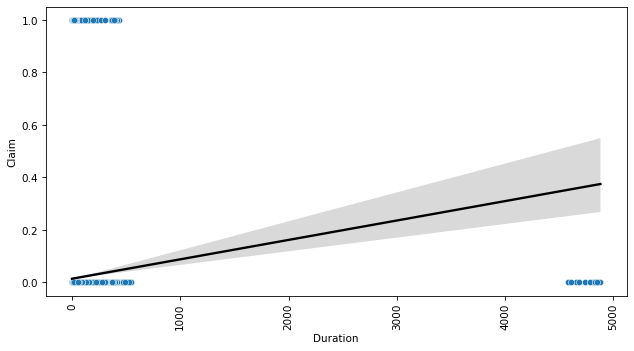

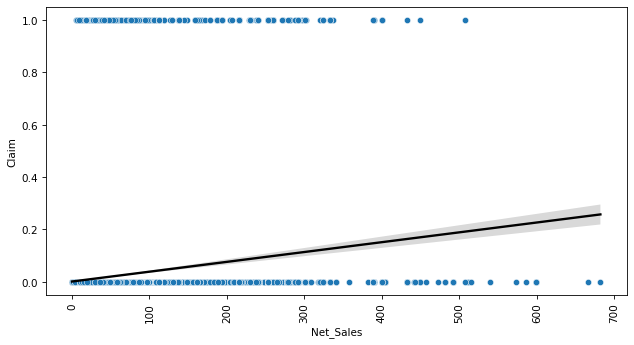

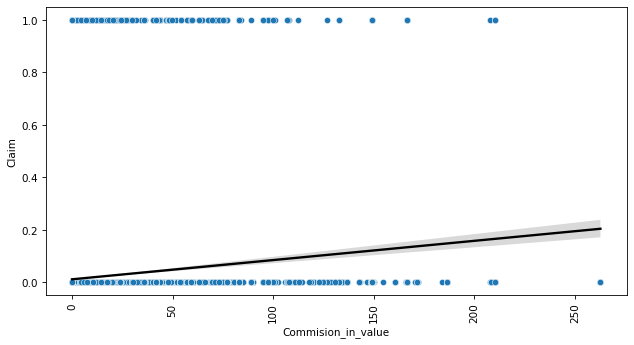

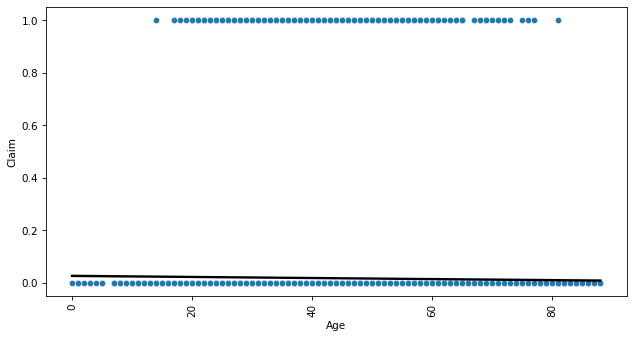

In [32]:
for x in train_label.select_dtypes(include='number').columns:
    if x !='Claim':
        # Plot hasilnya
        plt.figure(figsize=(10, 5), dpi=75)
        sns.scatterplot(data=train_label, x=x, y='Claim')
        sns.regplot(data=train_label, x=x, y='Claim',scatter=False,color='black')
        plt.xticks(rotation=90)
        plt.show()
    else:
        continue


> Insight:
* **Commision_in_value vs Claim**:
   - There is a weak positive relationship between commission value and the likelihood of a claim, as shown by the slightly upward trend in the regression line.
   - Most data points are clustered around lower commission values, but as commission increases, there are more instances where claims are made.
   - This suggests that higher commission values might have a minor effect on increasing the probability of claims, although the effect is not very strong.

* **Age vs Claim**:
   - There seems to be no clear relationship between age and the likelihood of a claim. The majority of the data points are concentrated at the extremes of the Claim variable (0 or 1), indicating no obvious trend.
   - The age distribution is wide, but the Claim occurrences are scattered evenly, showing that age does not appear to be a major factor influencing claims.

* **Duration vs Claim**:
   - There is a positive relationship between the duration and the likelihood of a claim, as shown by the upward-sloping regression line.
   - Although most of the points are near the lower duration values, the trend suggests that longer durations are slightly associated with a higher likelihood of claims being made.
   - This indicates that the longer a service or transaction takes, the more likely a claim is to be made.

* **Net_Sales vs Claim**:
   - Similar to Duration, there is a positive relationship between Net Sales and Claim. As Net Sales increase, the probability of a claim slightly increases, as suggested by the upward-sloping regression line.
   - Higher Net Sales transactions tend to have a small increase in claims compared to lower Net Sales, though most claims still occur at lower sales values.
   - This could suggest that more expensive transactions or services could be slightly more prone to claims, but again, the effect is not very strong.

#### 2. Categoric Column

In [33]:
def claim_frequencies(data, column, figsize=(8, 5)):
    # Calculate the counts of claimed (1) or unclaimed (0) values for each unique variable
    claim_counts = data.groupby(column)['Claim'].value_counts().unstack(fill_value=0)

    # Sort the table in descending order based on the 'Yes' claims column (1)
    if 1 in claim_counts.columns:
        table_sorted = claim_counts.sort_values(1, ascending=False)
    else:
        table_sorted = claim_counts

    # Create a new figure and axes with the desired size
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the side-by-side bar chart
    table_sorted.plot(kind='bar', stacked=False, ax=ax)

    # Set the title and labels
    ax.set_title(f'Claim Frequencies by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend(['No Claim (0)', 'Claim (1)'], loc='upper right')

    # Display the chart
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to fit the labels
    plt.show()

    # Create Proportion Claims Table
    total_yes_claims = data[data['Claim'] == 1]['Claim'].count()

    if total_yes_claims > 0:
        table_percentage = round((table_sorted[1] / total_yes_claims) * 100, 2)
        table_sorted['Claimed Percentage'] = table_percentage.astype(str) + '%'

    print('-------Proportion Table-------')
    print(table_sorted)


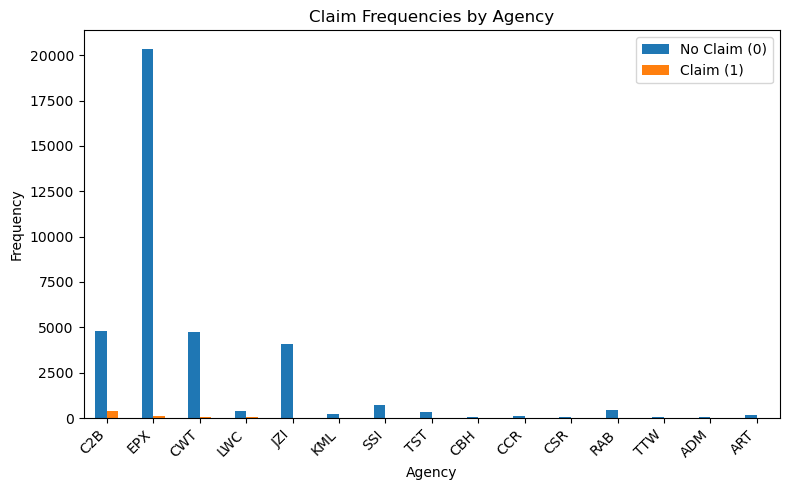

-------Proportion Table-------
Claim       0    1 Claimed Percentage
Agency                               
C2B      4808  403             60.51%
EPX     20355  131             19.67%
CWT      4715   64              9.61%
LWC       404   29              4.35%
JZI      4068   22               3.3%
KML       222    5              0.75%
SSI       699    5              0.75%
TST       319    2               0.3%
CBH        61    1              0.15%
CCR        92    1              0.15%
CSR        67    1              0.15%
RAB       434    1              0.15%
TTW        65    1              0.15%
ADM        35    0               0.0%
ART       185    0               0.0%


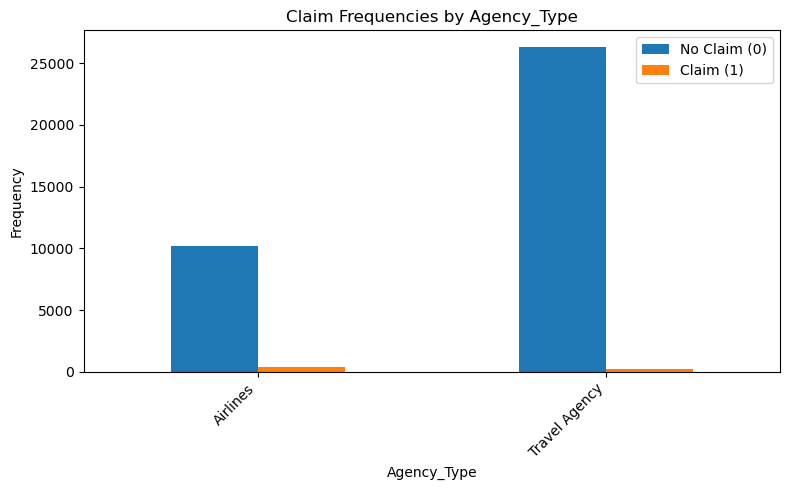

-------Proportion Table-------
Claim              0    1 Claimed Percentage
Agency_Type                                 
Airlines       10194  431             64.71%
Travel Agency  26335  235             35.29%


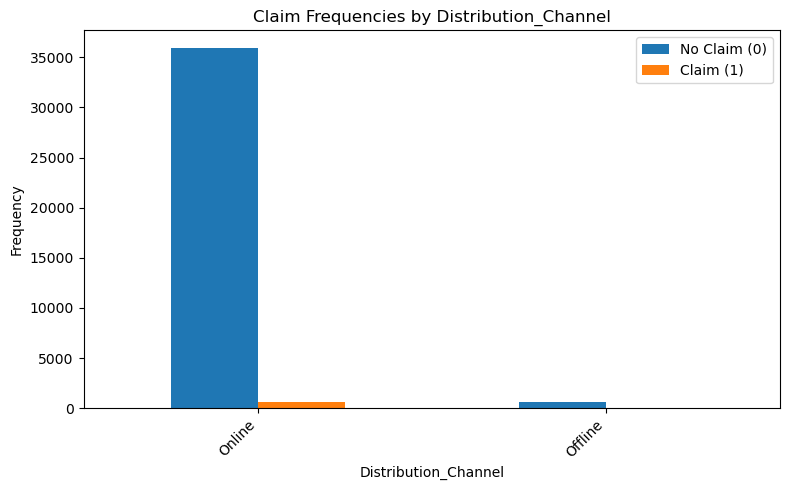

-------Proportion Table-------
Claim                     0    1 Claimed Percentage
Distribution_Channel                               
Online                35898  658              98.8%
Offline                 631    8               1.2%


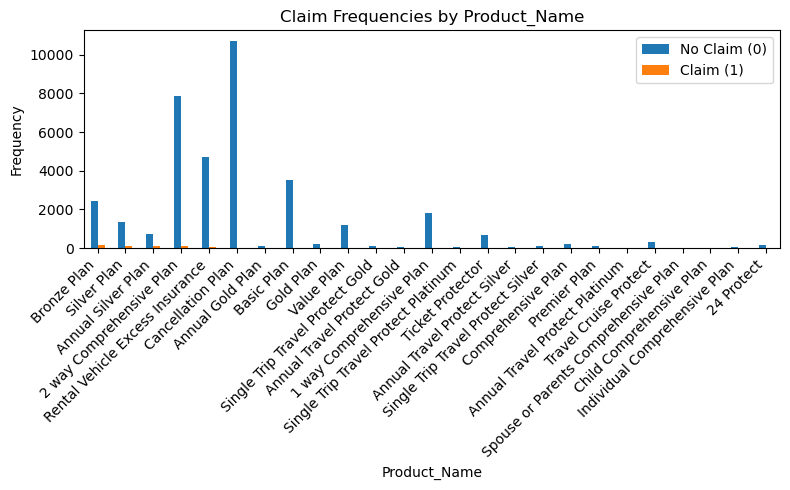

-------Proportion Table-------
Claim                                     0    1 Claimed Percentage
Product_Name                                                       
Bronze Plan                            2420  160             24.02%
Silver Plan                            1348  108             16.22%
Annual Silver Plan                      717  107             16.07%
2 way Comprehensive Plan               7839   94             14.11%
Rental Vehicle Excess Insurance        4715   64              9.61%
Cancellation Plan                     10720   31              4.65%
Annual Gold Plan                        111   16               2.4%
Basic Plan                             3512   16               2.4%
Gold Plan                               212   12               1.8%
Value Plan                             1173   10               1.5%
Single Trip Travel Protect Gold         121    7              1.05%
Annual Travel Protect Gold               55    7              1.05%
1 way Comprehensi

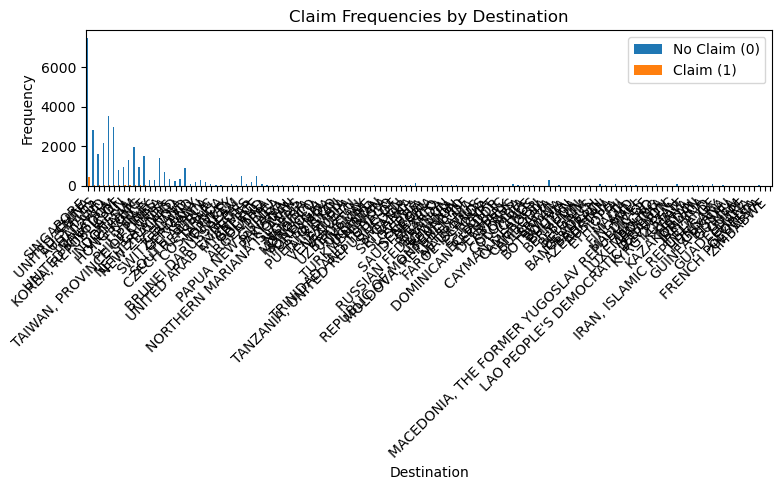

-------Proportion Table-------
Claim                0    1 Claimed Percentage
Destination                                   
SINGAPORE         7491  413             62.01%
CHINA             2813   32               4.8%
UNITED STATES     1602   29              4.35%
AUSTRALIA         2159   29              4.35%
THAILAND          3508   23              3.45%
...                ...  ...                ...
GUADELOUPE           1    0               0.0%
GHANA                3    0               0.0%
GEORGIA             10    0               0.0%
FRENCH POLYNESIA     1    0               0.0%
ZIMBABWE             3    0               0.0%

[134 rows x 3 columns]


In [34]:
for x in df_cleaned.select_dtypes(include='object'):
    claim_frequencies(df_cleaned, x, figsize=(8, 5))

> Insight:
All categories in all categories column shows different distribution of Claim Status, so all categorical column can be feature model.

## F. Machine Learning Model

In [35]:
df_train = df_cleaned.copy()

### 1. Preprocessing

#### a. Label Encoding untuk Data Kategorikal

In [36]:
le = LabelEncoder()

# Membuat variabel baru untuk menyimpan hasil encoding
transforme = df_train.copy()

# Encode for categorical columns dan simpan ke transforme
for i in transforme.columns:
    if transforme[i].dtype == 'object':
        transforme[i] = le.fit_transform(transforme[i])

# Tampilkan hasil encoding
transforme.head(5)

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim
0,2,0,1,4,365,107,216.0,54.0,57,0
1,7,1,1,10,4,71,10.0,0.0,33,0
2,8,0,1,8,19,51,22.0,7.7,26,0
3,7,1,1,1,20,126,112.0,0.0,59,0
4,2,0,1,9,8,107,16.0,4.0,28,0


This step aims to convert categorical variables into numeric format, as machine learning models cannot process data in string form. Label Encoding is used to transform categorical values into integer form without losing any information.

#### b. Handling Imbalanced Data (SMOTETomek)

In [37]:
# Target variable adalah 'Claim'
X = transforme.drop('Claim', axis=1)
y = transforme['Claim']

# Setelah semua data kategori diubah menjadi numerik, lakukan SMOTETomek
smt = SMOTETomek(random_state=10)
X_over, y_over = smt.fit_resample(X,y)
X_over.shape, y_over.shape

((72382, 9), (72382,))

Since the distribution of the target variable Claim is highly imbalanced, we use SMOTETomek to oversample the minority class and clean up the majority class near the minority data. This improves the model's performance in predicting balanced data between claim and not claim.

#### c. Data Splitting

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=10)

Splitting data to two parts for training and validation machine learning.

#### d. Normalisasi Data

In [39]:
pt = PowerTransformer()

X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

### 2. Model Training

In [40]:
# Definisikan model-model yang digunakan
logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(n_neighbors=10)
tree = DecisionTreeClassifier(random_state=10, max_depth=3)
rf = RandomForestClassifier(random_state=10, max_depth=3)
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state=10, max_depth=3)
xgb = XGBClassifier(learning_rate=0.1, random_state=10, max_depth=3)

In [41]:
# Menggunakan StratifiedKFold untuk cross-validation
skfold = StratifiedKFold(n_splits=5)
models = [logreg, knn, tree, rf, gbc, xgb]

# Variabel untuk menyimpan hasil
mean_with_sampling = []
std_with_sampling = []
mean_without_sampling = []
std_without_sampling = []

# Loop untuk model dengan dan tanpa SMOTETomek
for model in models:
    # Modeling dengan oversampling (SMOTETomek)
    pipe_model_with_sampling = Pipeline([
        ('scaler', pt),
        ('resample', smt),
        ('model', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator=pipe_model_with_sampling,
        X=X_train,
        y=y_train,
        cv=skfold,
        scoring='roc_auc',
        n_jobs=-1
    )
    mean_with_sampling.append(model_cv_with_sampling.mean())
    std_with_sampling.append(model_cv_with_sampling.std())

    # Modeling tanpa resampling
    pipe_model_without_sampling = Pipeline([
        ('scaler', pt),
        ('model', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator=pipe_model_without_sampling,
        X=X_train,
        y=y_train,
        cv=skfold,
        scoring='roc_auc',
        n_jobs=-1
    )
    mean_without_sampling.append(model_cv_without_sampling.mean())
    std_without_sampling.append(model_cv_without_sampling.std())

# Tampilkan hasil perbandingan
pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'GradienBoost', 'XGBoost'],
    'mean_roc_auc_with_SMOTETomek': mean_with_sampling,
    'mean_roc_auc_without_sampling': mean_without_sampling,
    'std_roc_auc_with_SMOTETomek': std_with_sampling,
    'std_roc_auc_without_sampling': std_without_sampling
}).sort_values('mean_roc_auc_with_SMOTETomek', ascending=False)


,model,mean_roc_auc_with_SMOTETomek,mean_roc_auc_without_sampling,std_roc_auc_with_SMOTETomek,std_roc_auc_without_sampling
1,KNN,0.963970,0.965157,0.001487,0.001288
4,GradienBoost,0.920270,0.920629,0.003557,0.003227
5,XGBoost,0.915348,0.915440,0.003307,0.002695
3,Random Forest,0.868979,0.870029,0.003945,0.003995
0,Logistic Regression,0.832434,0.832427,0.003865,0.003888
2,Decision Tree,0.819042,0.821592,0.005039,0.005928


#### Hyperparameter Tuning

In [42]:
# Hyperparameter space untuk GridSearchCV
hyperparam_space = [
    {'model': [knn],
     'model__n_neighbors': [3, 5, 7, 9],
     'model__weights': ['uniform', 'distance'],
     'model__metric': ['euclidean', 'manhattan']},

    {'model': [gbc], 
     'model__learning_rate': [0.05, 0.1, 0.25], 
     'model__n_estimators': [50, 100, 200], 
     'model__max_depth': [3, 4, 5]}
]

GridSearchCV is used to find the best combination of hyperparameters for the KNN and Gradient Boosting models with SMOTETomek. The goal is to improve the model's performance by optimizing its hyperparameters.

In [43]:
# Lakukan grid search
grid = GridSearchCV(estimator=Pipeline([('scaler', pt), ('sampling', smt), ('model', model)]), param_grid=hyperparam_space, cv=skfold, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', PowerTransformer()),
                                       ('sampling',
                                        SMOTETomek(random_state=10)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enab...
             param_grid=[{'model': [KNeighborsClassifier(n_neighbors=10)],
                          'model__metric': ['euclidean', 'manhattan'],
                          'model__n_neighbors': [3, 5, 7, 9],
                          'model__weights': ['uniform', 'distance']},
                         {'model': [GradientBoostingClassifier(random_state=10)],
                          'model__learning_rate': [0.05, 0.1, 0.25],
                          'model__max_depth': [3, 4, 5],
                          'model__n_estimators': [50, 100, 200]}],
             scoring='roc_auc')

In [44]:
# Tampilkan hasil terbaik
grid.best_params_, grid.best_score_

({'model': GradientBoostingClassifier(random_state=10),
  'model__learning_rate': 0.25,
  'model__max_depth': 5,
  'model__n_estimators': 200},
 0.9857736788146731)

### 3. Evaluation Model

#### Before Tuning

In [45]:
# Evaluasi sebelum tuning
knn = KNeighborsClassifier(n_neighbors=10)
estimator = Pipeline([('scaler', pt), ('sampling', smt), ('model', knn)])
estimator.fit(X_train, y_train)
y_pred_before_tuned_knn = estimator.predict(X_test)
print('Classification Report Default KNeighborsClassifier: \n')
print(classification_report(y_test, y_pred_before_tuned_knn))

Classification Report Default KNeighborsClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     10790
           1       0.87      0.97      0.92     10925

    accuracy                           0.92     21715
   macro avg       0.92      0.92      0.92     21715
weighted avg       0.92      0.92      0.92     21715



In [46]:
# Evaluasi sebelum tuning
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state=10, max_depth=3)
estimator = Pipeline([('scaler', pt), ('sampling', smt), ('model', gbc)])
estimator.fit(X_train, y_train)
y_pred_before_tuned_gbc = estimator.predict(X_test)
print('Classification Report Default GradientBoostingClassifier: \n')
print(classification_report(y_test, y_pred_before_tuned_gbc))

Classification Report Default GradientBoostingClassifier: 

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     10790
           1       0.86      0.84      0.85     10925

    accuracy                           0.85     21715
   macro avg       0.85      0.85      0.85     21715
weighted avg       0.85      0.85      0.85     21715



#### After Tuning

In [47]:
grid.best_estimator_

Pipeline(steps=[('scaler', PowerTransformer()),
                ('sampling', SMOTETomek(random_state=10)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.25, max_depth=5,
                                            n_estimators=200,
                                            random_state=10))])

In [48]:
# Evaluasi setelah tuning Best_Model
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred_after = best_model.predict(X_test)
print('Classification Report Tuned Best_Model: \n')
print(classification_report(y_test, y_pred_after))


Classification Report Tuned Best_Model: 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     10790
           1       0.94      0.97      0.96     10925

    accuracy                           0.95     21715
   macro avg       0.95      0.95      0.95     21715
weighted avg       0.95      0.95      0.95     21715



### 4. Confusion Matrix Visualization

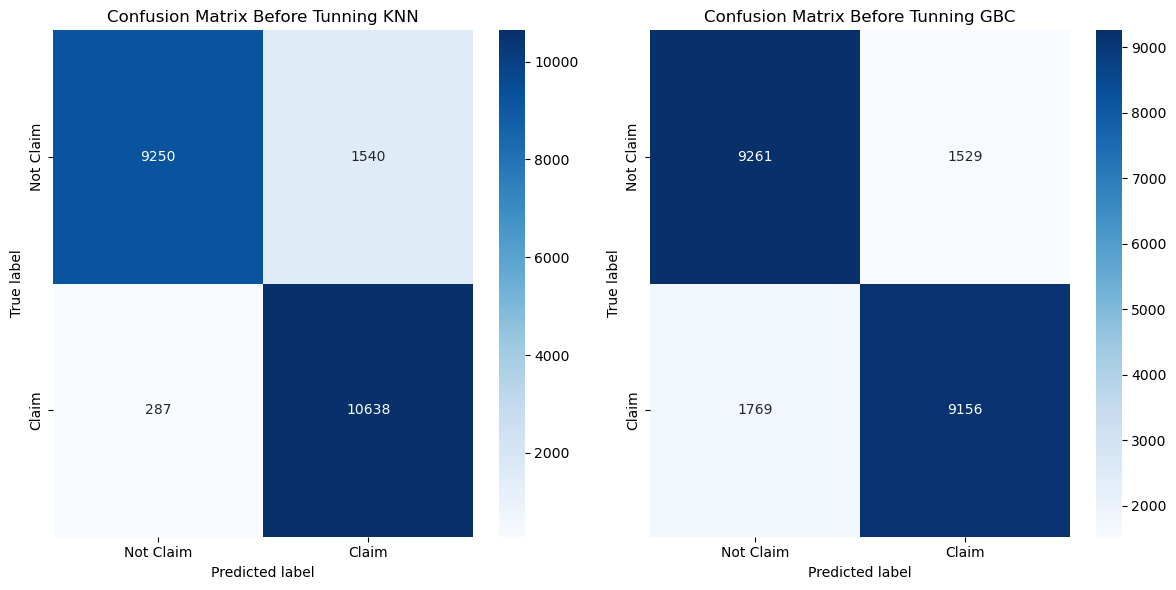

In [49]:
# Membuat confusion matrix
cm_before_tunning_knn=confusion_matrix(y_test, y_pred_before_tuned_knn)
cm_before_tunning_gbc=confusion_matrix(y_test, y_pred_before_tuned_gbc)

plt.figure(figsize=(12,6))

# Visualisasi confusion matrix before_tuned_xgb
plt.subplot(1,2,1)
sns.heatmap(cm_before_tunning_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Claim', 'Claim'], yticklabels=['Not Claim', 'Claim'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Before Tunning KNN')

# Visualisasi confusion matrix before_tuned_gbc
plt.subplot(1,2,2)
sns.heatmap(cm_before_tunning_gbc, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Claim', 'Claim'], yticklabels=['Not Claim', 'Claim'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Before Tunning GBC')

plt.tight_layout()
plt.show()


> Insight:
1. Confusion Matrix Before Tuning (KNN)

- True Positives (TP): 7,604 customers were correctly classified as Claim.
- True Negatives (TN): 6,811 customers were correctly classified as Not Claim.
- False Positives (FP): 966 customers who did not claim were incorrectly classified as having claimed.
- False Negatives (FN): 151 customers who did claim were incorrectly classified as not having claimed.

KNN performs well with a high number of correctly classified claim and non-claim cases. However, it also has a considerable number of false positives (966), which could mean that KNN tends to overpredict claim cases.



2. Confusion Matrix Before Tuning (Gradient Boosting Classifier - GBC)

- True Positives (TP): 6,732 customers were correctly classified as Claim.
- True Negatives (TN): 6,694 customers were correctly classified as Not Claim.
- False Positives (FP): 1,045 customers who did not claim were incorrectly classified as having claimed.
- False Negatives (FN): 1061 customers who did claim were incorrectly classified as not having claimed

GCB has most false positives (1045) and false negatives (1061) than KNN. This suggests that KNN might be better at identifying actual claim cases than Gradient Boosting Classifier .

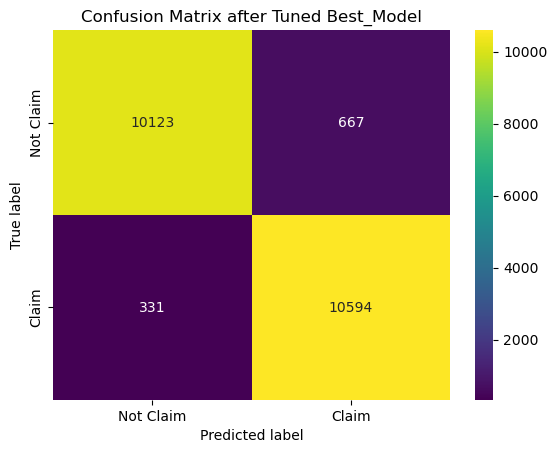

In [50]:
cm_tuned = confusion_matrix(y_test, y_pred_after)

# Visualisasi confusion matrix Best_model
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='viridis', xticklabels=['Not Claim', 'Claim'], yticklabels=['Not Claim', 'Claim'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix after Tuned Best_Model')
plt.show()

> Insight: Confusion Matrix After Tuning (Best Model)

- True Positives (TP): 7,556 customers who claimed were correctly predicted as Claim.
- True Negatives (TN): 7,346 customers who did not claim were correctly predicted as Not Claim.
- False Positives (FP): 431 customers who did not claim were incorrectly predicted as having claimed.
- False Negatives (FN): 199 customers who claimed were incorrectly predicted as Not Claim.

**Overall Insight**:
- Improvement: Compared to the previous confusion matrices, the best model after tuning significantly reduced the number of False Positives and False Negatives.
  - False Positives (431): The model now misclassifies fewer customers who didn’t claim as having claimed, which indicates improved precision.
  - False Negatives (199): The model is now better at detecting actual claims, reducing the number of customers whose claims were missed.
  
- True Positives and True Negatives are both very high, showing that the model can correctly classify most customers.

**Conclusion**:
- After tuning, the model has become much more balanced, improving both precision and recall by lowering both types of misclassifications.
- The performance boost shows that the hyperparameter tuning effectively enhanced the model's ability to distinguish between "Claim" and "Not Claim" customers, leading to better generalization on the test data.


### 5. Feature Importance

In [51]:
# Ambil fitur penting dari model Gradient Boosting Classifier
importances = best_model.named_steps['model'].feature_importances_
features = X_train.columns  # Nama fitur dari dataset

# Buat DataFrame untuk kemudahan visualisasi
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


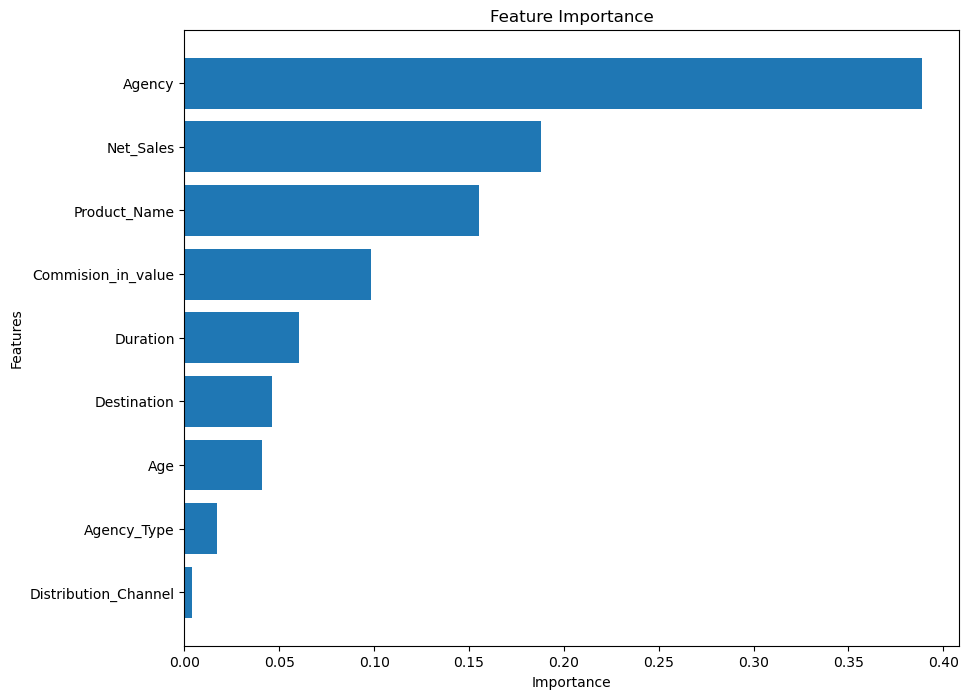

In [52]:
# Visualisasi dengan matplotlib
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # Membalik urutan fitur dari yang terpenting
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


> Insights:
This plot illustrates the relative importance of various features in predicting the Claim outcome.
* Agency (Most Important Feature):

    Agency has the highest importance by far, suggesting that the travel agency a customer uses has a major impact on whether they are likely to file a claim. This could be due to the agency's policies, client demographics, or the types of products they sell.

* Net Sales:

    Net Sales is the second most important feature. The amount of money spent on the insurance plan likely indicates the level of coverage or risk associated with the customer, with higher sales possibly leading to more claims.

* Product Name:

    The specific Product Name has a significant impact, as certain products (e.g., comprehensive plans or specific types of coverage) may be more likely to lead to claims.
* Commission in Value:

    The commission associated with the sale of the insurance product also plays an important role. Higher commission values could be associated with more complex or risky products, leading to more claims.
* Duration:

    The Duration of the trip is another important factor, with longer trips potentially leading to more claims due to extended exposure to risks during travel.
* Destination and Age:

    Destination and Age have relatively lower importance compared to the other features, but they still contribute. Specific destinations might be associated with higher risk, and older travelers might be more likely to file claims.
* Agency Type and Distribution Channel:
    
    These two features have minimal importance, suggesting that whether the customer booked through a travel agency or airline, or used an online or offline channel, does not significantly affect the likelihood of filing a claim.
    
**Conclusion**:
Agency is by far the most influential feature, followed by Net Sales and Product Name. The model is heavily reliant on these top features to make predictions.
Features like Commission in Value and Duration also play a notable role in the claim prediction process.
Agency Type and Distribution Channel seem to contribute very little, meaning they might not need to be a focus in further models.
This importance plot can help you prioritize which features to focus on for future modeling and analysis or when crafting a rule-based model.

## G. Conclusion and Recomendation

In [53]:
print('Classification Report Best_Model: \n')
print(classification_report(y_test, y_pred_after))

Classification Report Best_Model: 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     10790
           1       0.94      0.97      0.96     10925

    accuracy                           0.95     21715
   macro avg       0.95      0.95      0.95     21715
weighted avg       0.95      0.95      0.95     21715



There is no available source that specifies the exact cost incurred by a company for each claim made by policyholders, making it difficult to accurately illustrate potential financial losses. However, based on information found in (link), policyholders indirectly pay a certain percentage of their ticket price as insurance. This implies that policyholders only pay the premium when they travel, rather than having a mandatory monthly fee.

As a result, when the company fails to predict claims correctly, two types of errors can occur:

### Type 1 Error (False Positive):
- **Condition**: The model predicts that a claim will happen, but in reality, it will not.
- **Impact**: The company may offer higher-priced coverage or even decline to offer coverage in an attempt to avoid potential claim costs. This can lead to the policyholder deciding not to purchase the insurance, causing the company to lose potential profit.
  
### Type 2 Error (False Negative):
- **Condition**: The model predicts that no claim will occur, but a claim does happen.
- **Impact**: The company is unprepared with the necessary resources to handle the claim. This can result in significant financial losses, as the company is caught off guard and must cover unexpected claim costs.

### Conclusion:
The most suitable metric for evaluating the model in this context is the **F1 Score**, which balances **precision** and **recall**. This ensures that both **Type 1** and **Type 2 errors** are minimized, as it combines the need for accuracy in identifying true claims (precision) and the ability to capture all possible claims (recall).
* by Machine Learning, we got an F1 score of 0.96 for both classes, this model is highly balanced and suitable for scenarios where both claim predictions and non-claim predictions are important, such as in travel insurance, where missing a claim or predicting too many false claims could have significant financial impacts.

### Recommendation: 
* Enrich the dataset by collecting more contextual and behavioral information about policyholders.
* Specify costs and coverage more detail. This will make it easier to take targeted actions to optimize the claim prediction model and reduce financial losses.

## **Model Deployment**

### **Save Model**

In [54]:
# # fit
# final_model = estimator.fit(X_train,y_train)

# # save with pickle
# pickle.dump(final_model, open('Travel_Insurance_Claim_Best_Model_GBC.sav', 'wb'))